In [2]:
import numpy as np
import deproject, HandShapeAnalysis, h5py
from homography import pyrs12, spaces
import matplotlib.pyplot as plt
import pptk
import cv2 as cv
import matplotlib

/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: FutureWarning: pybind11-bound class 'pyrealsense2.processing_block' is using an old-style placement-new '__init__' which has been deprecated. See the upgrade guide in pybind11's docs. This message is only visible when compiled in debug mode.
  return f(*args, **kwds)
/anaconda3/lib/python3.6/importlib/_bootstrap.py:219: FutureWarning: pybind11-bound class 'pyrealsense2.filter' is using an old-style placement-new '__init__' which has been deprecated. See the upgrade guide in pybind11's docs. This message is only visible when compiled in debug mode.
  return f(*args, **kwds)


In [3]:
!ls "../recording_data/"

1_tap.hdf5                 Vhdf5_20190131_175522.hdf5
2_tap.hdf5                 Vhdf5_20190131_175535.hdf5
2_zoomin_yes.hdf5          Vhdf5_20190131_175550.hdf5
2_zoomout_yes.hdf5         Vhdf5_20190131_175604.hdf5
4_move_left_yes.hdf5       labeled
4_move_right_yes.hdf5


In [4]:
h5f = h5py.File("../recording_data/2_tap.hdf5", 'r')
pcl_center = h5f['pcl_center'][...]
trans_matrix = h5f['trans_matrix'][...]
depth_frame= h5f['depth']
color_frame= h5f['color']

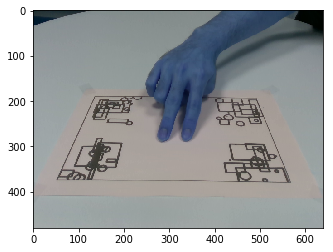

In [5]:
plt.imshow(color_frame[13])

In [6]:
depth_frame.shape

(59, 480, 640)

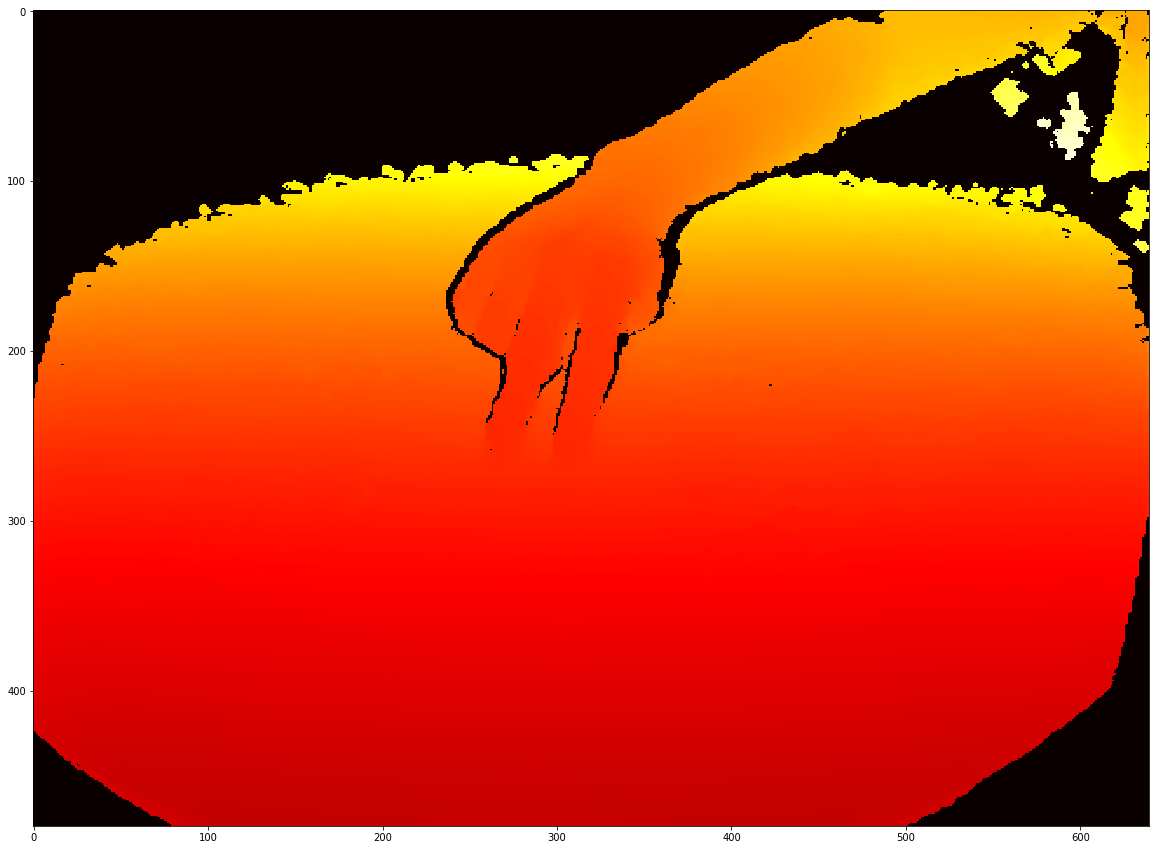

In [7]:
plt.figure(figsize = (20,15))
plt.imshow(depth_frame[13], cmap='hot', aspect='auto')

In [8]:
CLOUD = HandShapeAnalysis.depth2cloud(depth_frame[13],trans_matrix,pcl_center)

In [10]:
pptk.viewer(CLOUD)

In [11]:
ROI = CLOUD[HandShapeAnalysis.ROI_filter(CLOUD)[0]]

In [10]:
pptk.viewer(ROI[ROI[:,2]>0.001])

In [12]:
def PCA(data, correlation = False, sort = True):
    mean = np.mean(data, axis=0)

    data_adjust = data - mean

    #: the data is transposed due to np.cov/corrcoef syntax
    if correlation:

        matrix = np.corrcoef(data_adjust.T)

    else:
        matrix = np.cov(data_adjust.T) 

    eigenvalues, eigenvectors = np.linalg.eig(matrix)

    if sort:
        #: sort eigenvalues and eigenvectors
        sort = eigenvalues.argsort()[::-1]
        eigenvalues = eigenvalues[sort]
        eigenvectors = eigenvectors[:,sort]

    return eigenvalues, eigenvectors

In [13]:
PCA(ROI)

(array([0.00959918, 0.0071546 , 0.00022483]),
 array([[ 0.99407431,  0.10723298,  0.01781469],
        [ 0.10494005, -0.98943551,  0.10002479],
        [-0.02835245,  0.0975626 ,  0.99482545]]))

In [13]:
def best_fitting_plane(points, equation=False):
    w, v = PCA(points)

    #: the normal of the plane is the last eigenvector
    normal = v[:,2]

    #: get a point from the plane
    point = np.mean(points, axis=0)


    if equation:
        a, b, c = normal
        d = -(np.dot(normal, point))
        return a, b, c, d
        #ax+by+cz=d
        #z=(d-ax-by)/c

    else:
        return point, normal   

In [14]:
a,b,c,d=best_fitting_plane(ROI,True)

In [15]:
np.max(ROI[:,0])

0.1769956

In [16]:
np.max(ROI[:,1])

0.13464993

In [17]:
np.min(ROI[:,0])

-0.177

In [18]:
np.min(ROI[:,1])

-0.18464787

In [19]:
PLANE = []
a,b,c,d=best_fitting_plane(ROI,True)
for x in np.arange(-0.18,0.18,0.001):
    for y in np.arange(-0.19,0.14,0.001):
        PLANE.append([x,y,(-d-a*x-b*y)/c])
    #z=(d-ax+by)/c
PLANE=np.array(PLANE)

In [20]:
pptk.viewer(ROI)

In [21]:
pptk.viewer(np.concatenate((PLANE,ROI)))

In [22]:
def sampler(n,points):
    """return n random rows of data (and also the other len(data)-n rows)"""
    return points[np.random.choice(len(points), n, replace=False)]

class PLANE():
    def __init__(self):
        self.center = None
        self.normal = None
    def fit(self, points):
        normal = np.cross(points[1] - points[0], points[2] - points[0])
        self.center = points[0]
        self.normal = normal / np.linalg.norm(normal)
    def get_error(self, points):
        vectors = points - self.center
        distances = np.abs(np.dot(vectors, self.normal))
        return distances
def ransac(points,model=PLANE(), sampler=sampler, iterations=100, threshold=3e-3, min_required=100):
    i = 0
    best_inliers = None
    while i < iterations:
        n_points = sampler(3,points)
        
        model.fit(n_points)
        err = model.get_error(points)
    
        inliers = err <= threshold
        n_inliers = np.sum(inliers)
        
        if n_inliers > min_required:
            best_inliers = inliers
            min_required = n_inliers
        i+=1
    if best_inliers is None:
        raise ValueError("did not meet fit acceptance criteria")
    return best_inliers

In [23]:
ROI = CLOUD[HandShapeAnalysis.ROI_filter(CLOUD)[0]]

In [24]:
ROI_non_zero = np.where(ROI[:,2]>=0, ROI[:,2],np.zeros(shape=ROI.shape[:1]))
ROI[:,2] = ROI_non_zero

In [25]:
ROI[:,2] = ROI_non_zero

In [26]:
filter_ = ransac(ROI, model=PLANE(), sampler=sampler, iterations=100, threshold=3e-3, min_required=100)

In [27]:
ROI[filter_]

array([[ 0.17696194, -0.18307635,  0.00282433],
       [ 0.17586856, -0.18318357,  0.00275638],
       [ 0.17477563, -0.18329093,  0.00268862],
       ...,
       [-0.05674489,  0.13463312,  0.00075991],
       [-0.05730348,  0.13463415,  0.00075768],
       [-0.05786223,  0.13463527,  0.00075536]], dtype=float32)

In [28]:
np.array([0.17696194, -0.18307635,  0.00282433]) - np.array([0.15878035,0.09472766,0.00041804])

array([ 0.01818159, -0.27780401,  0.00240629])

In [29]:
pptk.viewer(ROI[np.invert(filter_)])

In [30]:
pptk.viewer(np.concatenate((ROI,ROI[np.invert(filter_)])))

In [29]:
ROI_filter = HandShapeAnalysis.ROI_filter(CLOUD)[0]

In [30]:
ROI_filter[ROI_filter==True] = np.invert(filter_)

In [31]:
len(ROI_filter)

307200

# Success

In [12]:
def filter_by_min(points, cloud_min):
    shape = points.shape[0:-1]
    return (points.reshape(-1,3)[:,2]>cloud_min).reshape(shape)

def filter_by_ransac(points):
    shape = points.shape[0:-1]
    return np.invert(ransac(points.reshape(-1,3))).reshape(shape)

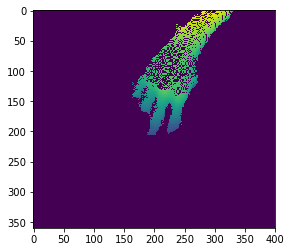

In [9]:
image= depth_frame[13]
point = HandShapeAnalysis.depth2cloud(depth_frame[13],trans_matrix,pcl_center)

point = point.reshape((480, 640, 3))[image != 0].reshape((-1,3))
roi, ratio= HandShapeAnalysis.ROI_filter(point)

intrease_area = point[roi]
cloud_image = HandShapeAnalysis.cloud2bird_image(intrease_area, ratio,np.min(intrease_area[:,0]), np.max(intrease_area[:,0]), np.min(intrease_area[:,1]), np.max(intrease_area[:,1]))

cloud_image[cloud_image[:,:,2]<0.02] = np.array([0,0,0])#exclude table
image = cloud_image[:,:,2]
plt.imshow(image)

In [10]:
image= depth_frame[13]
point = HandShapeAnalysis.depth2cloud(depth_frame[13],trans_matrix,pcl_center)

point = point.reshape((480, 640, 3))[image != 0].reshape((-1,3))
roi, ratio= HandShapeAnalysis.ROI_filter(point)

intrease_area = point[roi]
intrease_area_non_zero = np.where(intrease_area[:,2]>=0, intrease_area[:,2],np.zeros(shape=intrease_area.shape[0:-1]))
intrease_area[:,2] = intrease_area_non_zero

cloud_image = HandShapeAnalysis.cloud2bird_image(intrease_area[filter_by_ransac(intrease_area)], ratio,np.min(intrease_area[:,0]), np.max(intrease_area[:,0]), np.min(intrease_area[:,1]), np.max(intrease_area[:,1]) )
plt.imshow(cloud_image[:,:,2])

NameError: name 'filter_by_ransac' is not defined

In [35]:
%timeit filter_by_min(intrease_area,0.02)

132 µs ± 15.7 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [36]:
%timeit filter_by_ransac(intrease_area)

507 ms ± 35 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [13]:
%load_ext cython

In [14]:
%%cython --annotate
import numpy as np
cimport numpy as np
cimport cython
from libc.stdlib cimport malloc, free, rand, RAND_MAX

def random_sample(int range_, int sample_size):
    idx = np.empty(sample_size, dtype=np.int)
    for i in range(sample_size):
        idx[i]=int((rand()/RAND_MAX)*range_)
    return idx

def ransac(np.ndarray[float, ndim=2]points, int iterations=100, float threshold=3e-3, int min_required=100):
    cdef int i = 0
    cdef int length = len(points)
    cdef np.ndarray index
    cdef np.ndarray[np.uint8_t, ndim = 1,cast=True] best_inliers
    
    cdef np.ndarray[float, ndim=1] center
    cdef np.ndarray[float, ndim=1] normal
    
    cdef np.ndarray[np.uint8_t, ndim = 1,cast=True] inliers
    cdef int n_inliers
    
    while i < iterations:
        index = random_sample(length, 3)
        n_points = points[index]

        normal = np.cross(np.subtract(n_points[1], n_points[0]), np.subtract(n_points[2] , n_points[0]))
        center = n_points[0]
        normal = np.divide(normal, np.linalg.norm(normal))
        
        vectors = np.subtract(points, center)
        distances = np.abs(np.dot(vectors, normal))

        inliers = distances <= threshold
        n_inliers = np.sum(inliers)

        if n_inliers > min_required:
            # print(n_inliers)
            best_inliers = inliers
            min_required = n_inliers
        i+=1
    if best_inliers is None:
        raise ValueError("did not meet fit acceptance criteria")
    return best_inliers



def filter_by_ransac(np.ndarray[float, ndim=2]points):
    return np.reshape(np.invert(ransac(points.reshape(-1,3))), np.shape(points)[0:-1])

In [15]:
random_sample(len(intrease_area),3)

array([ 86367, 118838,  48759])

In [16]:
filter_by_ransac(intrease_area)

array([ True,  True,  True, ..., False, False, False])

In [18]:
%timeit filter_by_ransac(intrease_area)

224 ms ± 27.9 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [39]:
import .deproject

In [19]:
from deproject import filter_by_ransac

In [ ]:
filter_by_ransac(intrease_area)

/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in true_divide
  """Entry point for launching an IPython kernel.
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:1: RuntimeWarning: invalid value encountered in less_equal
  """Entry point for launching an IPython kernel.


In [2]:
from importlib import reload
reload(homography.deproject)

<module 'homography.deproject' from '/Users/tom/Documents/multi-touch/notebook/homography/deproject.cpython-36m-darwin.so'>

# test

In [88]:
%load_ext cython

The cython extension is already loaded. To reload it, use:
  %reload_ext cython


In [259]:
%%cython --annotate
import numpy as np
cimport numpy as np
cimport cython
from libc.stdlib cimport malloc, free, rand, RAND_MAX

# disable index bounds checking and negative indexing for speedups
@cython.wraparound(False)
@cython.boundscheck(False)
def cython_get_sample(np.ndarray arr, int arr_len, int sample_size):
        np.random.shuffle(arr)
        return arr[0:sample_size] 
    
def npsum(np.ndarray arr):
    cdef int sum_
    for i in arr:
        sum_+=i
    return arr

def npsum2(np.ndarray arr, int sum_):
    return np.sum(arr)


In [260]:
len(intrease_area)

127142

In [262]:
%timeit npsum(intrease_area[:,1])

428 ms ± 35.1 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [255]:
%timeit npsum2(intrease_area,10)

171 µs ± 5.98 µs per loop (mean ± std. dev. of 7 runs, 10000 loops each)


In [151]:
%timeit cython_get_sample(intrease_area, len(intrease_area),3)

170 ms ± 7.38 ms per loop (mean ± std. dev. of 7 runs, 1 loop each)


In [152]:
%timeit np.random.choice(len(intrease_area), 3, replace=False)

2.55 ms ± 211 µs per loop (mean ± std. dev. of 7 runs, 100 loops each)


In [236]:
%timeit random_three(127142, 3)

1.75 µs ± 61.1 ns per loop (mean ± std. dev. of 7 runs, 1000000 loops each)


In [125]:
%timeit random_three(len(intrease_area), 3)

2.82 µs ± 958 ns per loop (mean ± std. dev. of 7 runs, 100000 loops each)


In [135]:
print(random_three(len(intrease_area), 3))

[-15300 -12203 -13417]
